# Proyecto 2 Data Science. Análisis Exploratorio

Autores:

- Nelson García Bravatti
- Joaquín Puente
- José Antonio Mérida



### Imports / Librerías Utilizadas
Los requerimientos para este Jupyter Notebook se pueden instalar por medio de los siguientes comandos:

Crear el entorno virtual
```
python -m venv .venv
```

Activar el entorno (Windows)

```
.\.venv\Scripts\activate
```

Activar el entorno (Linux / Max)

```
source .venv/bin/activate
```

Instalar dependencias
```
pip install -r requirements.txt
```

In [3]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --quiet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import warnings
import kagglehub
from PIL import Image

warnings.filterwarnings('ignore')

## Análisis Inicial y Preprocesamiento de Datos





### Carga del Dataset
Optamos por descargar el set de datos mediante Kagglehub, almacenando el path a los datos dentro de la variable dataset_path para su uso a futuro.

In [5]:
# Descargar la versión más reciente
path = kagglehub.dataset_download("vishakkbhat/mosquito-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mosquito-data' dataset.
Path to dataset files: /kaggle/input/mosquito-data


In [6]:
# Setear el path del dataset
dataset_path = path
print(f"Dataset path: {dataset_path}")

Dataset path: /kaggle/input/mosquito-data


### Carga a DataFrames
Este dataset contiene los datos ya divididos en splits de entrenamiento y de prueba, por lo que podemos simplemente cargar la información a DataFrames de pandas utilizando read_csv.

In [7]:
# Load the training data
train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'test_phase1.csv'))
sample_submission = pd.read_csv(os.path.join(dataset_path, 'sample_submission_phase1 (1).csv'))

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Training data shape: (8025, 8)
Test data shape: (2675, 3)
Sample submission shape: (2675, 8)


El conjunto de entrenamiento contiene 8,025 muestras con 8 características cada una, que incluyen variables predictoras y la etiqueta objetivo. Los datos de prueba constan de 2,675 muestras con 3 características, sobre los cuales deberemos realizar predicciones. La plantilla de envío confirma que se esperan 2,675 predicciones con 8 campos cada una, consistentes con el formato requerido.

### Conjunto de Entrenamiento
Podemos investigar las características específicas de cada conjunto de datos para identificar las variables predictores y etiqueta objetivo, empezando por el conjunto de datos de entrenamiento.

**Variables y Tipos de Datos**

In [8]:
print(f"Tipos de datos:\n{train_df.dtypes}")

Tipos de datos:
img_fName      object
img_w           int64
img_h           int64
bbx_xtl         int64
bbx_ytl         int64
bbx_xbr         int64
bbx_ybr         int64
class_label    object
dtype: object


El dataset de entrenamiento contiene metadatos de imágenes para el problema de detección y clasificación de mosquitos. La columna ```img_fName``` identifica cada archivo de imagen, mientras que ```img_w``` e ```img_h``` especifican sus dimensiones. Las coordenadas de las cajas delimitadoras (```bbx_xtl```, ```bbx_ytl```, ```bbx_xbr```, ```bbx_ybr```) definen la localización precisa de los objetos dentro de las imágenes, y ```class_label``` indica la categoría de cada objeto detectado.

**Primeras Entradas**

In [9]:
train_df.head()

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,92715872-3287-4bff-aa61-7047973e5c02.jpeg,2448,3264,1301,1546,1641,2096,albopictus
1,b0f7cc74-2272-4756-a387-38bcaf6965c8.jpeg,3024,4032,900,1897,1950,2990,albopictus
2,82df4b68-0f45-4afe-9215-48488bf3720e.jpeg,768,1024,220,58,659,808,albopictus
3,331ad30a-7564-4478-b863-7bc760adf5a1.jpeg,3456,4608,1169,2364,1586,2826,albopictus
4,1a46dbfb-104e-466b-88d7-98958d7b1fe9.jpeg,1024,1365,129,231,697,1007,culex


Las primeras entradas se ven como esperamos, teniendo el nombre de la imagen, seguido de las dimensiones de la imagen y el bounding box y por último la especie del mosquito.

**Operaciones de Limpieza**

Para garantizar la calidad de los datos de entrenamiento, podemos implementar las siguientes operaciones de limpieza:

**Validación de coordenadas**: Verificar que todas las bounding boxes se encuentren dentro de los límites de las imágenes (0 ≤ x ≤ img_w, 0 ≤ y ≤ img_h)

**Filtrado por tamaño**: Identificar y revisar bounding boxes anómalamente pequeñas (<10 píxeles) o excesivamente grandes (>80% del área de la imagen, estándar para modelos de visión por computadora)

**Eliminación de duplicados**: Identificar y remover bounding boxes duplicadas para la misma imagen

**Eliminación de valores nulos**: Identificar y remover valores faltantes, en este caso no sería correcto reemplazarlos con alguna otra métrica ya que el bounding box representa la totalidad de una figura geométrica.

In [10]:
original_size = len(train_df)

print(f"Problemas Detectados")

# Verificar que las bbox están dentro de los límites de la imagen
invalid_bbox_mask = (
    (train_df['bbx_xtl'] < 0) | (train_df['bbx_xtl'] >= train_df['img_w']) |
    (train_df['bbx_ytl'] < 0) | (train_df['bbx_ytl'] >= train_df['img_h']) |
    (train_df['bbx_xbr'] <= 0) | (train_df['bbx_xbr'] > train_df['img_w']) |
    (train_df['bbx_ybr'] <= 0) | (train_df['bbx_ybr'] > train_df['img_h']) |
    (train_df['bbx_xbr'] <= train_df['bbx_xtl']) |
    (train_df['bbx_ybr'] <= train_df['bbx_ytl'])
)

invalid_count = invalid_bbox_mask.sum()
print(f"Bounding boxes fuera de límites: {invalid_count}")

# Calcular dimensiones y áreas
bbox_width = train_df['bbx_xbr'] - train_df['bbx_xtl']
bbox_height = train_df['bbx_ybr'] - train_df['bbx_ytl']
bbox_area = bbox_width * bbox_height
image_area = train_df['img_w'] * train_df['img_h']
area_ratio = bbox_area / image_area

# Bounding boxes demasiado pequeñas (<10 píxeles en cualquier dimensión)
too_small_mask = (bbox_width < 10) | (bbox_height < 10)
small_count = too_small_mask.sum()
print(f"Bounding boxes muy pequeñas (<10px): {small_count}")

# Bounding boxes demasiado grandes (>80% del área de la imagen)
too_large_mask = (area_ratio > 0.8)
large_count = too_large_mask.sum()
print(f"Bounding boxes muy grandes (>80% área): {large_count}")

# Duplicados exactos en coordenadas e imagen
duplicates_mask = train_df.duplicated(
    subset=['img_fName', 'bbx_xtl', 'bbx_ytl', 'bbx_xbr', 'bbx_ybr'],
    keep=False
)

duplicate_count = duplicates_mask.sum()
print(f"Bounding boxes duplicadas: {duplicate_count}")

# Verificar valores nulos
null_mask = train_df.isnull().any(axis=1)
null_count = null_mask.sum()
print(f"Valores nulos: {null_count}")

filter_mask = invalid_bbox_mask | too_small_mask | too_large_mask | duplicates_mask
filtered_count = filter_mask.sum()

train_df_clean = train_df[~filter_mask].copy()
final_size = len(train_df_clean)

print(f"\nResumen")
print(f"Tamaño original: {original_size}")
print(f"Registros eliminados: {filtered_count}")
print(f"Tamaño final: {final_size}")
print(f"Porcentaje conservado: {final_size/original_size*100:.2f}%")

Problemas Detectados
Bounding boxes fuera de límites: 5
Bounding boxes muy pequeñas (<10px): 1
Bounding boxes muy grandes (>80% área): 23
Bounding boxes duplicadas: 0
Valores nulos: 0

Resumen
Tamaño original: 8025
Registros eliminados: 29
Tamaño final: 7996
Porcentaje conservado: 99.64%


El proceso de limpieza identificó 29 registros problemáticos (0.36% del total), lo que indica un dataset de alta calidad. La ausencia de valores nulos y duplicados refleja una buena gestión inicial de los datos. Los principales problemas detectados son bounding boxes fuera de límites (5 casos) y dimensiones anómalas (24 casos), que probablemente corresponden a errores de anotación durante el etiquetado. La eliminación de estos registros asegura que el modelo entrene únicamente con anotaciones válidas, mejorando la confiabilidad del entrenamiento sin impactar significativamente el volumen de datos disponible (99.64% conservado).

**Visualización**

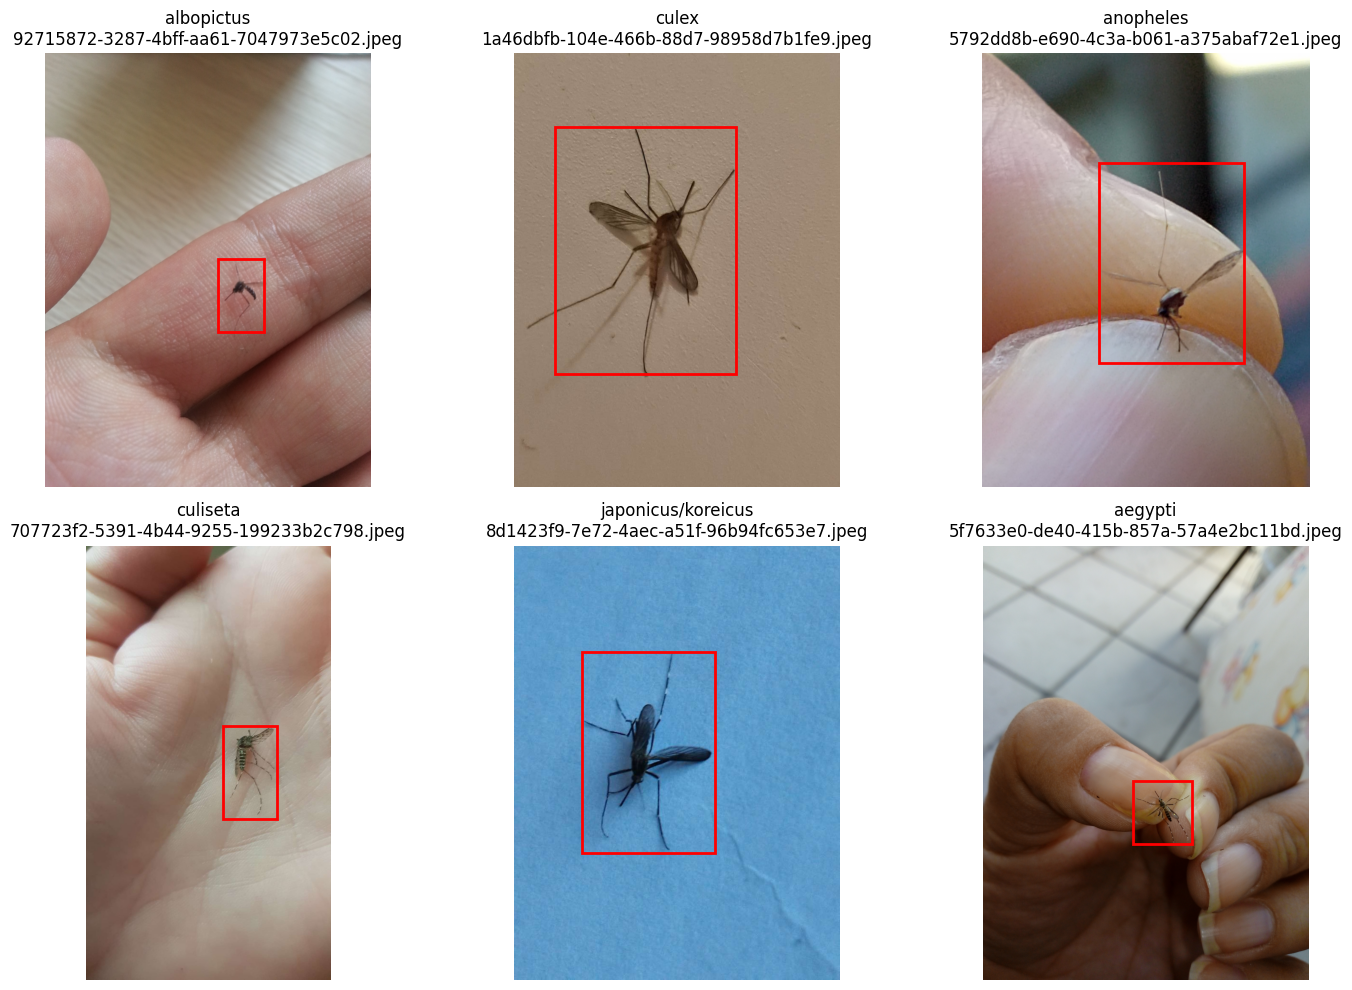

In [11]:
def display_sample_images(df, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    # Utilizar una imagen por cada clase
    classes = df['class_label'].unique()

    for i, class_name in enumerate(classes[:num_samples]):
        sample = df[df['class_label'] == class_name].iloc[0]

        # Cargar imagen
        img_path = os.path.join(dataset_path, 'train_images', sample['img_fName'])

        try:
            img = Image.open(img_path)
            axes[i].imshow(img)

            # Dibujar bounding box
            bbox = [sample['bbx_xtl'], sample['bbx_ytl'], sample['bbx_xbr'], sample['bbx_ybr']]
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                               fill=False, edgecolor='red', linewidth=2)
            axes[i].add_patch(rect)

            axes[i].set_title(f'{class_name}\n{sample["img_fName"]}')
            axes[i].axis('off')

        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading image\n{e}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{class_name} - Error')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(train_df)

Aquí podemos ver algunos de los ejemplos, dónde podemos observar que las imágenes tienden a tener fondos y tamaños de bounding box relativamente variados. Dentro del análisis exploratorio intentaremos encontrar diferentes patrones o tendencias para tener en mente al implementar un modelo de visión por computadora para realizar predicciones.

### Conjunto de Prueba

**Variables y Tipos de Datos**

In [12]:
print(f"Tipos de datos:\n{test_df.dtypes}")

Tipos de datos:
img_fName    object
img_w         int64
img_h         int64
dtype: object


El dataset de prueba contiene solo la información esencial para realizar inferencias: los nombres de archivo de las imágenes (img_fName) y sus dimensiones (img_w, img_h). La ausencia de bounding boxes y etiquetas de clase confirma que este es un conjunto para predicción pura, donde el modelo deberá detectar y clasificar automáticamente los mosquitos en cada imagen sin supervisión.

**Primeras Entradas**

In [13]:
test_df.head()

,img_fName,img_w,img_h
0,07e0f900-e1d2-4e3c-a812-651a156d7463.jpeg,4032,2268
1,98171e52-0def-4de8-b9ad-23cc3a1f1a2d.jpeg,2448,3264
2,30da361c-282e-4a8c-a714-4de4d5407696.jpeg,2988,5312
3,780ce034-878f-41fc-a23f-5432987ce64a.jpeg,3000,4000
4,6e7e3e96-62a4-46e3-aaa2-ce88f2949f6a.jpeg,4128,3096


Las primeras entradas se ven como esperamos, conteniendo el archivo correspondiente a la imagen al igual que sus dimensiones. Estas son las entradas para las pruebas del modelo sobre las cuales debe hacer predicciones.

**Operaciones de Limpieza**

Al ser el conjunto de prueba, no debemos realizar operaciones de limpieza sobre este conjunto.

In [14]:
sample_submission.head()

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,07e0f900-e1d2-4e3c-a812-651a156d7463.jpeg,4032,2268,3174,860,3624,2169,culex
1,98171e52-0def-4de8-b9ad-23cc3a1f1a2d.jpeg,2448,3264,1130,3092,2240,3209,culex
2,30da361c-282e-4a8c-a714-4de4d5407696.jpeg,2988,5312,2169,4426,2650,4899,albopictus
3,780ce034-878f-41fc-a23f-5432987ce64a.jpeg,3000,4000,2135,3171,2522,3849,culex
4,6e7e3e96-62a4-46e3-aaa2-ce88f2949f6a.jpeg,4128,3096,130,769,1830,2299,japonicus/koreicus


### Resumen

**Dataset Entrenamiento:**
- **Tamaño original**: 8,025 imágenes de entrenamiento
- **Tamaño después de limpieza**: 7,966 imágenes de entrenamiento
- **Clases**: 6 especies de mosquitos (albopictus, culex, culiseta, japonicus/koreicus, anopheles, aegypti)
- **Formato**: Imágenes JPEG con anotaciones de bounding boxes

**Dataset Prueba:**
- **Tamaño**: 2,675 imágenes
- **Formato**: Imágenes JPEG

**Problemas identificados y solucionados:**
- **Bounding boxes inválidos**: 5 casos removidos
- **Bounding boxes muy pequeños**: 1 caso removido
- **Bounding boxes muy grandes**: 23 casos identificados y corregidos

## Análisis exploratorio de datos (EDA)

### Descripción de Variables y Observaciones

In [15]:
# Tamaño del Dataset
print(f"Observaciones: {train_df_clean.shape[0]}")
print(f"Variables: {train_df_clean.shape[1]}")

# Tipos de Datos
print(train_df_clean.dtypes)

Observaciones: 7996
Variables: 8
img_fName      object
img_w           int64
img_h           int64
bbx_xtl         int64
bbx_ytl         int64
bbx_xbr         int64
bbx_ybr         int64
class_label    object
dtype: object


Luego de los procesos de limpieza, el conjunto de datos cuenta con 7996 observaciones y 8 variables. Dónde cada una de las entradas cuenta con la siguiente información:

```img_fName``` (object / string - Identificador Único): Nombre del archivo de imagen (ej: "92715872-3287-4bff-aa61-7047973e5c02.jpeg")

```img_w``` (int64 - Númerica): Ancho de la imagen en píxeles

```img_h``` (int64 - Numérica): Alto de la imagen en píxeles

```bbx_xtl``` (int64 - Numérica): Coordenada X del punto superior izquierdo de la bounding box

```bbx_ytl``` (int64 - Numérica): Coordenada Y del punto superior izquierdo de la bounding box

```bbx_xbr``` (int64 - Numérica): Coordenada X del punto inferior derecho de la bounding box

```bbx_ybr``` (int64 - Numérica): Coordenada Y del punto inferior derecho de la bounding box

```class_label``` (object / string - Categórica): Especie de mosquito (ej: "albopictus", "culex")


Dónde ```img_w```, ```img_h```, ```bbx_xtl```, ```bbx_ytl```, ```bbx_xbr```, ```bbx_ybr``` son nuestras variables numéricas, representando las dimensiones de las imágenes y ubicación del bounding box para el mosquito.

Por otro lado, ```class_label``` es la variable categórica que buscamos predecir y ```img_fName``` corresponde al nombre del archivo de la imagen.

### Resumen de Variables Numéricas
Para las variables numéricas, iremos una por una buscando describirlas. Adicionalmente, utilizaremos algunos valores derivados como lo pueden ser altos o anchos de bounding boxes para hacerlo más robusto. Al ser coordenadas, debemos ser cuidadosos con el análisis de las medidas.

**Dimensiones de Imagen: Estadísticas Descriptivas**

In [16]:
# Formato legible en Pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Resumen de dimensiones de imagen + tamaño calculado
resumen = train_df_clean[['img_w', 'img_h']].copy()
resumen['img_area'] = resumen['img_w'] * resumen['img_h']
resumen['img_ratio'] = resumen['img_w'] / resumen['img_h']
display(resumen.describe().round(2))

,img_w,img_h,img_area,img_ratio
count,7996.00,7996.00,7996.00,7996.00
mean,2044.22,2469.48,6282548.18,0.88
std,1183.76,1358.51,5895737.90,0.35
min,152.00,106.00,16112.00,0.36
25%,1024.00,1095.00,1397760.00,0.75
50%,1847.00,2208.00,3773952.00,0.75
75%,3024.00,4000.00,12000000.00,0.98
max,9280.00,12000.00,108000000.00,2.53


En cuánto al ancho y altura de la imagen, tenemos rangos de 152px a 9280px y 106px a 12000px respectivamente. Esto nos indica una alta variabilidad en el tamaño de la imagen, respaldado también por la desviación estandar de 1183.76px para el ancho y 1350.51px para la altura. Adicionalmente, utilizando la variable derivada de área podemos ver que la resolución promedio es de 6.3 megapíxeles, lo que representa una calidad aceptable-alta para modelos de visión por computadora. Sin embargo, la extrema variabilidad resulta en el 25% de las imágenes por debajo de 1.4 MPx (resolución baja) y un 25% sobre 12MPx (resolución sumamente alta). En cuanto a la relación de aspecto (img_ratio), observamos un valor promedio de 0.88 con una desviación estándar de 0.35, lo que indica una predominancia de formatos verticales en el dataset. El rango de 0.36 a 2.53 revela una diversidad significativa en las proporciones, desde imágenes muy verticales hasta formatos claramente horizontales. En este caso, el modelo debe ser robusto y poder interpretar de manera correcta las imágenes con dimensiones diferentes o también se puede considerar la normalización o redimensionamiento de las imágenes antes del entrenamiento.

**Dimensiones de Imagen: Visualizaciones**

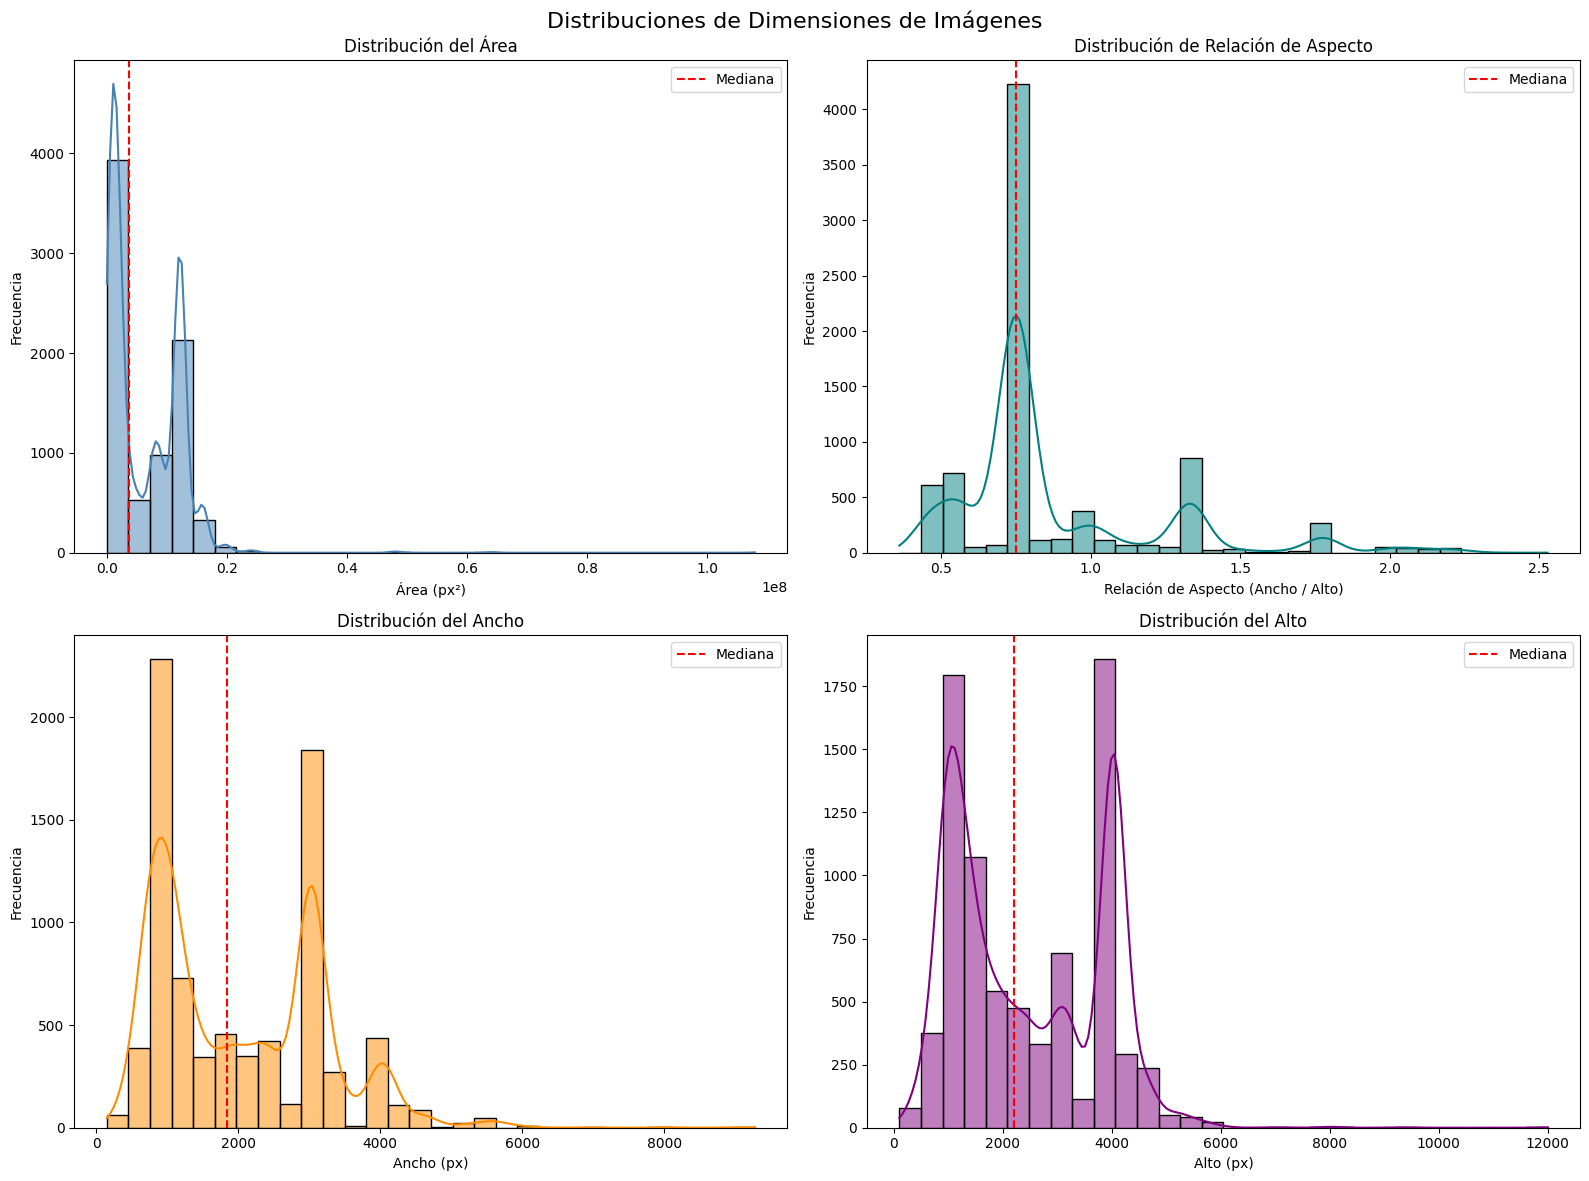

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuciones de Dimensiones de Imágenes', fontsize=16)

# 1. Distribución del área
sns.histplot(resumen['img_area'], bins=30, kde=True, ax=axes[0,0], color='steelblue')
axes[0,0].axvline(resumen['img_area'].median(), color='red', linestyle='--', label='Mediana')
axes[0,0].set_xlabel('Área (px²)')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución del Área')
axes[0,0].legend()

# 2. Distribución de la relación de aspecto
sns.histplot(resumen['img_ratio'], bins=30, kde=True, ax=axes[0,1], color='teal')
axes[0,1].axvline(resumen['img_ratio'].median(), color='red', linestyle='--', label='Mediana')
axes[0,1].set_xlabel('Relación de Aspecto (Ancho / Alto)')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución de Relación de Aspecto')
axes[0,1].legend()

# 3. Distribución del ancho
sns.histplot(resumen['img_w'], bins=30, kde=True, ax=axes[1,0], color='darkorange')
axes[1,0].axvline(resumen['img_w'].median(), color='red', linestyle='--', label='Mediana')
axes[1,0].set_xlabel('Ancho (px)')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución del Ancho')
axes[1,0].legend()

# 4. Distribución del alto
sns.histplot(resumen['img_h'], bins=30, kde=True, ax=axes[1,1], color='purple')
axes[1,1].axvline(resumen['img_h'].median(), color='red', linestyle='--', label='Mediana')
axes[1,1].set_xlabel('Alto (px)')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title('Distribución del Alto')
axes[1,1].legend()

plt.tight_layout()
plt.show()

Observando las gráficas, nos podemos dar cuenta que el dataset contiene imágenes bastante variadas. Las imagenes cuentan con resoluciones (área) bastante variadas a pesar de acumularse principalmente dentro de un rango, y lo mismo se puede decir para el ancho y el alto de la imagen. Esto es de esperarse, ya que el tamaño / área de la imagen es un atributo derivado. En cuánto a relación de aspecto, podemos darnos cuenta que hay imágenes bastante anchas y angostas a pesar de ser alrededor de 4:3 la mayoría. Podemos apoyarnos de boxplots para intentar identificar valores atípicos dentro de las variables de área y relación de aspecto. Este tipo de factores se deben de tomar en cuenta al momento de aplicar técnicas de resizing o normalización.

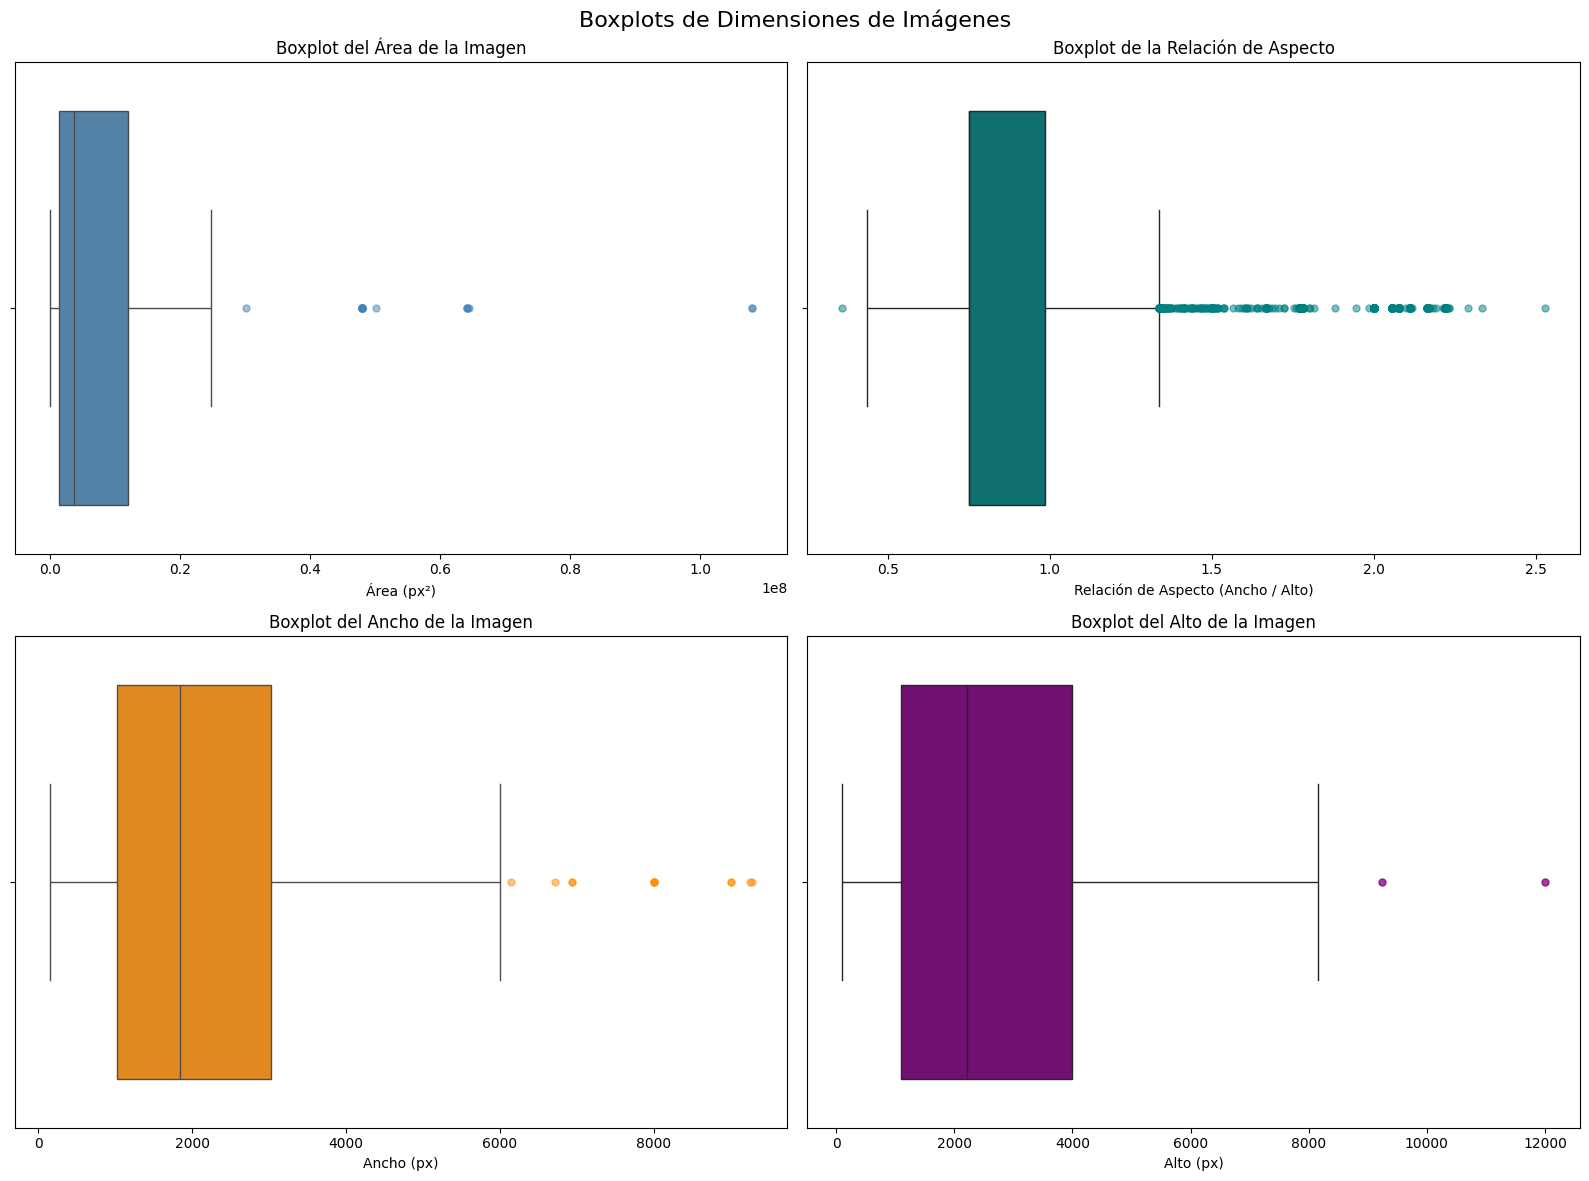

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Boxplots de Dimensiones de Imágenes', fontsize=16)

# Función para generar flierprops con color de la caja y sin borde
def flier_props(color):
    return dict(marker='o', markersize=5, markerfacecolor=color, markeredgecolor=color, alpha=0.5)

# 1. Boxplot del área
sns.boxplot(x=resumen['img_area'], ax=axes[0,0], color='steelblue', flierprops=flier_props('steelblue'))
axes[0,0].set_xlabel('Área (px²)')
axes[0,0].set_title('Boxplot del Área de la Imagen')

# 2. Boxplot de la relación de aspecto
sns.boxplot(x=resumen['img_ratio'], ax=axes[0,1], color='teal', flierprops=flier_props('teal'))
axes[0,1].set_xlabel('Relación de Aspecto (Ancho / Alto)')
axes[0,1].set_title('Boxplot de la Relación de Aspecto')

# 3. Boxplot del ancho
sns.boxplot(x=resumen['img_w'], ax=axes[1,0], color='darkorange', flierprops=flier_props('darkorange'))
axes[1,0].set_xlabel('Ancho (px)')
axes[1,0].set_title('Boxplot del Ancho de la Imagen')

# 4. Boxplot del alto
sns.boxplot(x=resumen['img_h'], ax=axes[1,1], color='purple', flierprops=flier_props('purple'))
axes[1,1].set_xlabel('Alto (px)')
axes[1,1].set_title('Boxplot del Alto de la Imagen')

plt.tight_layout()
plt.show()


Observando los boxplots, podemos darnos cuenta que en ambos casos contamos con valores atípicos. Por el lado de área de imagen, contamos con algunas imágenes que tienen resoluciones sumamente altas, mientras la mayoría se encuentra en rangos inferiores. En cuanto a relación de aspecto, contamos con múltiples imágenes consideradas outliers dónde las imágenes son más verticales en comparación a las demás. Los outliers en área y relación de aspecto sugieren filtrar o tratar valores extremos, o usar técnicas de data augmentation para simular estas variaciones y que el modelo tenga una mejor capacidad de generalizar.

**Dimensiones y Ubicacion Bounding Box: Estadísticas Descriptivas**

Para esta parte, se trabajará con las coordenadas relativas del bounding box, ya que los valores absolutos dependen del tamaño de la imagen y no permiten comparar de manera consistente el tamaño o la posición de los mosquitos. Los valores relativos (0–1) indican de manera uniforme la proporción de la imagen ocupada por el mosquito y su ubicación dentro de la misma, siendo adecuados para análisis exploratorio.

In [19]:
# Coordenadas relativas del bounding box (0 a 1)
resumen['bbx_xtl_rel'] = train_df_clean['bbx_xtl'] / train_df_clean['img_w']
resumen['bbx_ytl_rel'] = train_df_clean['bbx_ytl'] / train_df_clean['img_h']
resumen['bbx_xbr_rel'] = train_df_clean['bbx_xbr'] / train_df_clean['img_w']
resumen['bbx_ybr_rel'] = train_df_clean['bbx_ybr'] / train_df_clean['img_h']

# Ancho, alto y centro relativos
resumen['bbx_w_rel'] = resumen['bbx_xbr_rel'] - resumen['bbx_xtl_rel']
resumen['bbx_h_rel'] = resumen['bbx_ybr_rel'] - resumen['bbx_ytl_rel']
resumen['bbx_cx_rel'] = (resumen['bbx_xtl_rel'] + resumen['bbx_xbr_rel']) / 2
resumen['bbx_cy_rel'] = (resumen['bbx_ytl_rel'] + resumen['bbx_ybr_rel']) / 2
resumen['bbx_area_rel'] = resumen['bbx_w_rel'] * resumen['bbx_h_rel']

# Crear DataFrame con únicamente las variables relativas del bounding box
resumen_rel = resumen[['bbx_xtl_rel', 'bbx_ytl_rel',
                       'bbx_xbr_rel', 'bbx_ybr_rel',
                       'bbx_w_rel', 'bbx_h_rel',
                       'bbx_cx_rel', 'bbx_cy_rel',
                       'bbx_area_rel']].copy()

# Mostrar estadísticas descriptivas de los valores relativos
pd.set_option('display.float_format', '{:.6f}'.format)
display(resumen_rel.describe().round(2))

,bbx_xtl_rel,bbx_ytl_rel,bbx_xbr_rel,bbx_ybr_rel,bbx_w_rel,bbx_h_rel,bbx_cx_rel,bbx_cy_rel,bbx_area_rel
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000
mean,0.320000,0.350000,0.660000,0.640000,0.340000,0.290000,0.490000,0.500000,0.130000
std,0.130000,0.130000,0.130000,0.130000,0.200000,0.190000,0.080000,0.090000,0.140000
min,0.000000,0.000000,0.190000,0.160000,0.020000,0.030000,0.110000,0.090000,0.000000
25%,0.240000,0.260000,0.570000,0.560000,0.180000,0.150000,0.440000,0.440000,0.030000
50%,0.330000,0.360000,0.640000,0.630000,0.290000,0.240000,0.490000,0.500000,0.070000
75%,0.410000,0.440000,0.750000,0.720000,0.460000,0.400000,0.540000,0.550000,0.180000
max,0.880000,0.800000,1.000000,1.000000,1.000000,0.970000,0.940000,0.850000,0.790000


Observando las coordenadas superiores izquierdas (```bbx_xtl_rel```, ```bbx_ytl_rel```) tienen medias de 0.32 y 0.35 respectivamente, indicando que en promedio, los mosquitos se encuentran ligeramente desplazados al centro desde la esquina superior izquierda. Las coordenadas inferiores derechas (```bbx_xbr_rel```, ```bbx_ybr_rel```) presentan medias de 0.66 y 0.64, sugiriendo que los bounding boxes ocupan aproximadamente un tercio a la mitad del ancho y alto de la imagen. En cuanto a desviación estándar, es relativamente baja. Esto indica que la mayoría de mosquitos se encuentran en posiciones similares, aunque los valores de mínimos y máximos indican que hay casos en dónde los mosquitos aparecen cerca de los bordes.

En cuanto al tamaño relativo del bounding box, ```bbx_w_rel``` y ```bbx_h_rel``` muestran medias de 0.34 y 0.29, respectivamente, con una dispersión moderada (desviaciones estándar de 0.20 y 0.19), lo que indica que la mayoría de los mosquitos ocupan un área pequeña a media dentro de la imagen, aunque hay algunos bounding boxes que cubren hasta casi la totalidad del ancho o del alto de la imagen (máximos de 1.0 y 0.97). La media del área relativa (```bbx_area_rel```) es de 0.13, lo que confirma que los mosquitos suelen ocupar alrededor del 13 % del área total de la imagen, con casos extremos donde el área del bounding box puede alcanzar hasta un 79 % de la imagen.

Respecto al centro del bounding box (```bbx_cx_rel```, ```bbx_cy_rel```), las medias de 0.49 y 0.50 indican que, en promedio, los mosquitos están centrados tanto horizontal como verticalmente dentro de las imágenes, lo cual es útil para modelos de detección que pueden asumir que el objeto de interés tiende a aparecer cerca del centro. Sin embargo, los valores mínimo y máximo muestran cierta variabilidad, con centros que van desde casi un décimo hasta cerca del borde de la imagen, lo que sugiere que el modelo también debe ser capaz de generalizar a posiciones no centrales.

**Dimensiones y Ubicacion Bounding Box: Visualización**

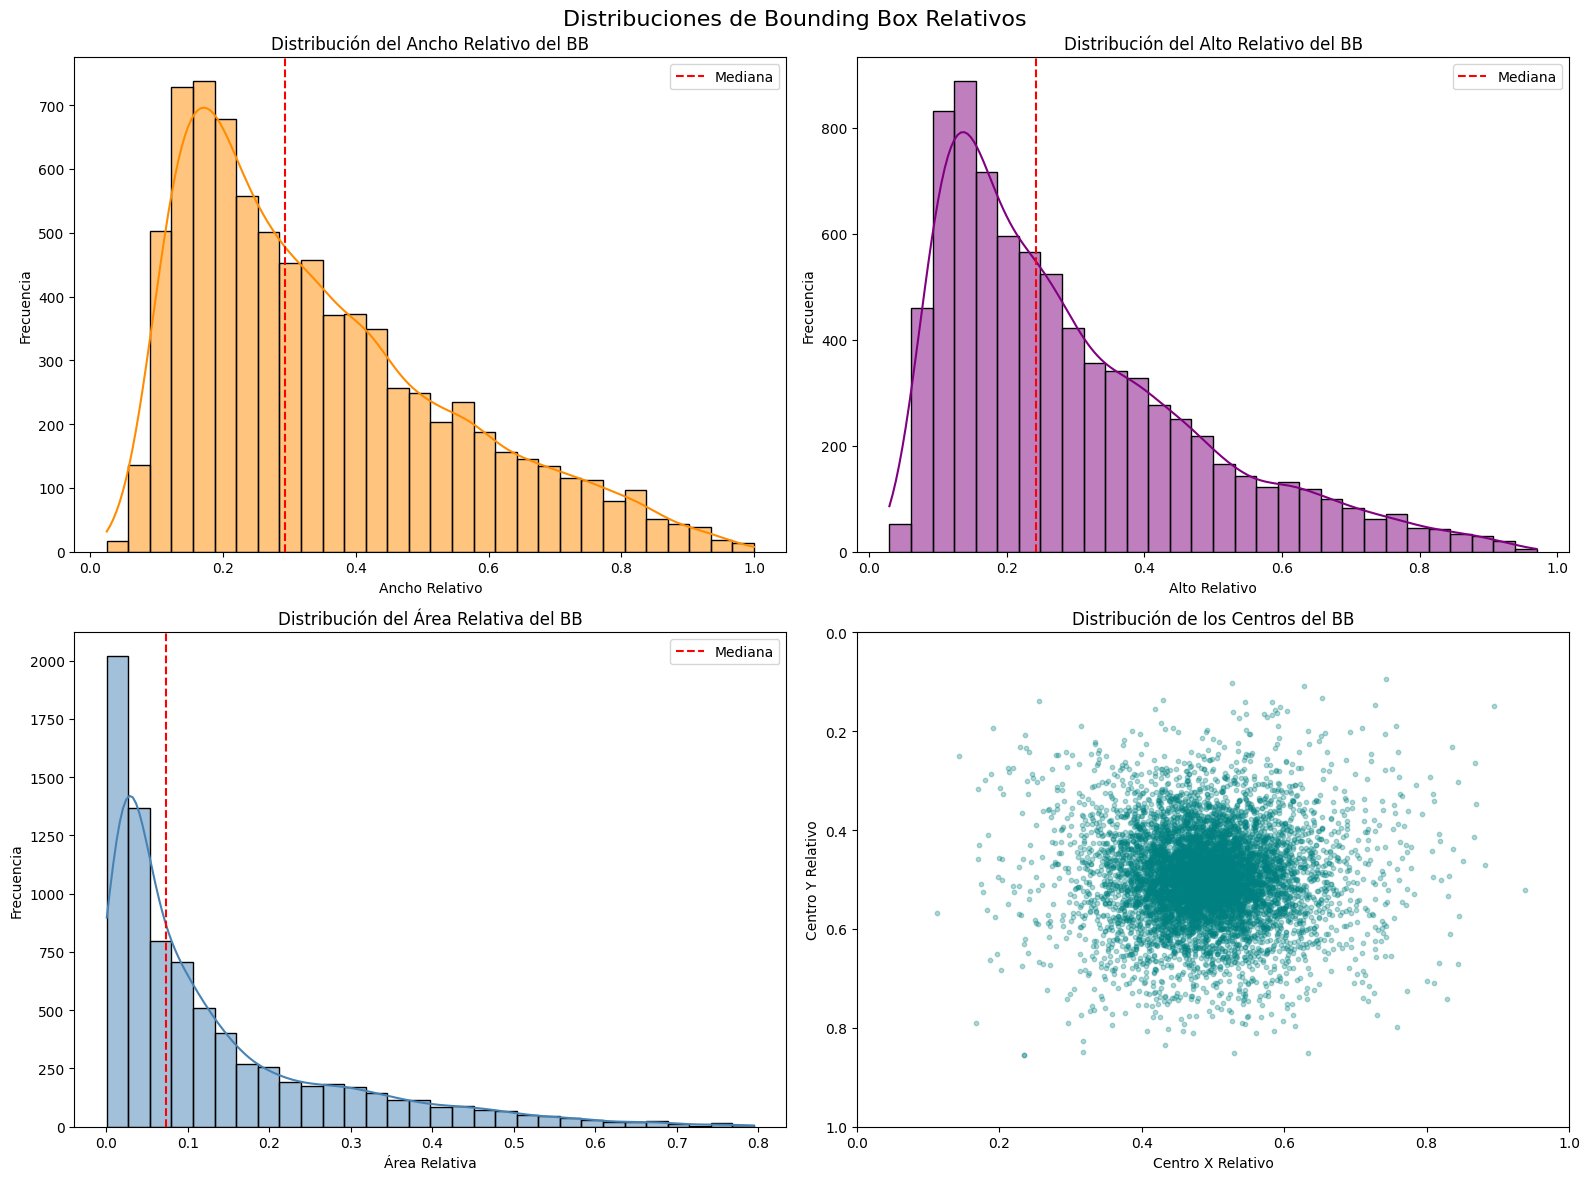

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuciones de Bounding Box Relativos', fontsize=16)

# 1. Distribución del ancho relativo
sns.histplot(resumen['bbx_w_rel'], bins=30, kde=True, ax=axes[0,0], color='darkorange')
axes[0,0].axvline(resumen['bbx_w_rel'].median(), color='red', linestyle='--', label='Mediana')
axes[0,0].set_xlabel('Ancho Relativo')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución del Ancho Relativo del BB')
axes[0,0].legend()

# 2. Distribución del alto relativo
sns.histplot(resumen['bbx_h_rel'], bins=30, kde=True, ax=axes[0,1], color='purple')
axes[0,1].axvline(resumen['bbx_h_rel'].median(), color='red', linestyle='--', label='Mediana')
axes[0,1].set_xlabel('Alto Relativo')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución del Alto Relativo del BB')
axes[0,1].legend()

# 3. Distribución del área relativa
sns.histplot(resumen['bbx_area_rel'], bins=30, kde=True, ax=axes[1,0], color='steelblue')
axes[1,0].axvline(resumen['bbx_area_rel'].median(), color='red', linestyle='--', label='Mediana')
axes[1,0].set_xlabel('Área Relativa')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución del Área Relativa del BB')
axes[1,0].legend()

# 4. Scatter de los centros relativos
axes[1,1].scatter(resumen['bbx_cx_rel'], resumen['bbx_cy_rel'], alpha=0.3, s=10, color='teal')
axes[1,1].set_xlabel('Centro X Relativo')
axes[1,1].set_ylabel('Centro Y Relativo')
axes[1,1].set_title('Distribución de los Centros del BB')
axes[1,1].set_xlim(0,1)
axes[1,1].set_ylim(0,1)
axes[1,1].invert_yaxis()  # Para coincidir con coordenadas de imagen (0,0 arriba izquierda)

plt.tight_layout()
plt.show()


Observando las primeras tres gráficas, nos podemos dar cuenta que los bounding box siguen una distribución bastante sesgada hacia la izquierda. Esto nos indica que la mayoría ocupan un espacio pequeño de la imagen totan, encontrando la media alrededor del 7-8% de la imagen. En cuanto al centro relativo, en la gráfica podemos ver que en la mayoría de las imágenes el mosquito es el enfoque central de la imagen. Sin embargo, también tenemos casos dónde la caja se encuentra en diversas posiciones. La mayoría de los mosquitos aparecen cerca del centro de la imagen, pero con cierta variabilidad; esto indica que los modelos de detección no pueden asumir siempre que el objeto estará centrado y deben generalizar a posiciones variadas

### Resumen de Variables Categóricas

In [21]:
# Tabla de frecuencias
freq_table = train_df_clean['class_label'].value_counts().reset_index()
freq_table.columns = ['class_label', 'count']
freq_table['percentage'] = (freq_table['count'] / freq_table['count'].sum() * 100).round(2)

display(freq_table)

,class_label,count,percentage
0,albopictus,3557,44.480000
1,culex,3533,44.180000
2,culiseta,488,6.100000
3,japonicus/koreicus,319,3.990000
4,anopheles,63,0.790000
5,aegypti,36,0.450000


Dentro del dataset tenemos 6 clases diferentes, sin embargo logramos encontrar 2 clases totalmente predominantes. ```albopictus``` y ```culex``` conforman el 88% de las entradas del dataset, con alrededor del 44% cada uno. Esto debe de tomarse en cuenta a la hora de trabajar con modelaje, ya que este desbalanceo de clases puede llevar a resultados erróneos. Adicionalmente, debemos notar la falta de representación de las clases ```anopheles``` y ```aegypti```, contando con 63 y 36 observaciones respectivamente.

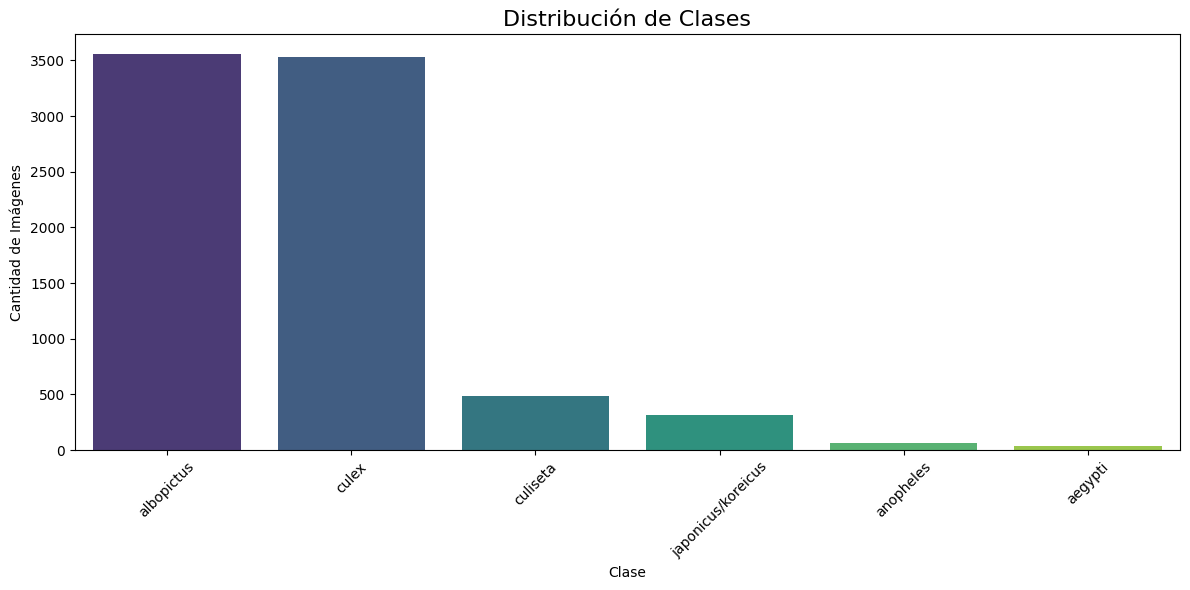

In [22]:
# Gráfica de Barras
plt.figure(figsize=(12,6))
sns.barplot(data=freq_table, x='class_label', y='count', palette='viridis')
plt.title('Distribución de Clases', fontsize=16)
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El desbalanceo de clases descrito en el inciso anterior se puede observar visualmente en la gráfica de barras, dónde seguimos presentando 2 clases completamente predominantes y 2 clases con muy pocas observaciones. Esto implica que será necesario aplicar técnicas de balanceo como oversampling, weighting en la función de pérdida, o data augmentation específico para clases minoritarias.

### Patrones Clave
El investigar patrones clave fue bastante dificultoso, ya que la mayoría de variables numéricas son derivadas o se relacionan entre ellas. Por ejemplo, una imagen más ancha probablemente sea más alta y definitivamente tendrá una resolución más alta (al ser un valor derivado). Por otro lado, la información del bounding box también consta primariamente de valores derivados.

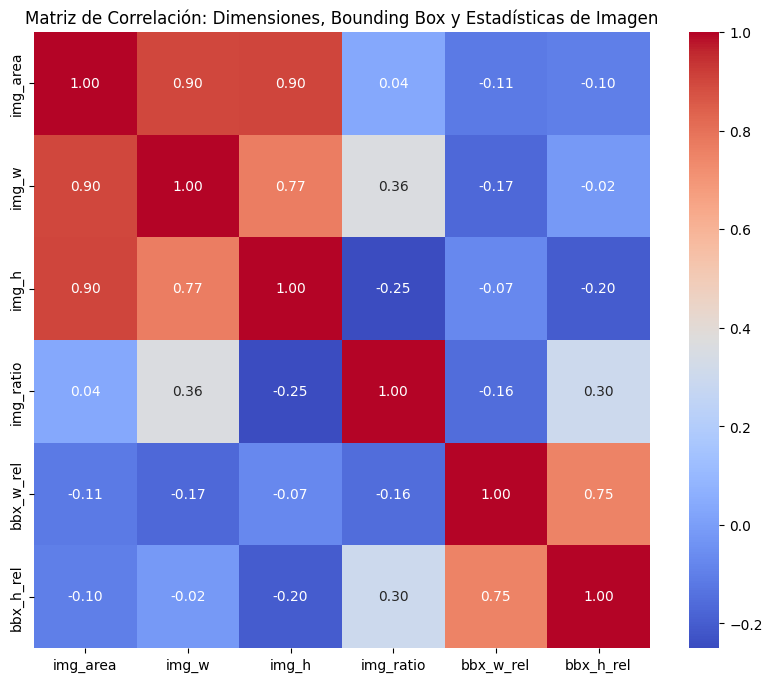

In [23]:
# Selección de variables numéricas para correlación
variables_corr = [
    'img_area', 'img_w', 'img_h', 'img_ratio',
    'bbx_w_rel', 'bbx_h_rel',
]

# Subset
df_corr = resumen[variables_corr]

# Calcular correlación
corr_matrix = df_corr.corr()

# Graficar
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de Correlación: Dimensiones, Bounding Box y Estadísticas de Imagen")
plt.show()


Al interpretar la matriz de correlación, es crucial tener cuidado para no caer en la trampa de ver relaciones poco influyentes. En este caso, esperamos que los primeros 3 valores y los últimos 3 se relacionen enter ellos, al ser todos derivados uno del otro. Esto quiere decir que las relaciones realmente se tendrían que presentar en el sector inferior izquierdo o superior derecho. En cuánto a los valores de la matriz de correlación, no parece existir relación alguna entre las dimensiones de la imagen y las dimensiones del bounding box. La matriz de correlación únicamente indica relación entre atributos derivados.

In [24]:
# plt.figure(figsize=(10,6))
# sns.boxplot(
#     data=resumen,
#     x='class_label',
#     y='img_area',
#     palette='Set2'
# )
# plt.yscale('log')
# plt.title('Distribución del Área de Imagen por Especie de Mosquito (log scale)')
# plt.xlabel('Especie de Mosquito')
# plt.ylabel('Área de Imagen (px², log scale)')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


Según el boxplot, la mayoría de especies comparte rangos similares de resolución de imágen. Sin embargo, tenemos algunos casos dónde tenemos distribuciones más "apretadas" cómo ```anophetes``` o ```aegypti```. Eso debe mantenerse en consideración, ya que es posible que el modelo descarte características de una imagen de alta resolución de alguna imagen correspondiente a una de estas especies únicamente basado en la falta de observaciones.

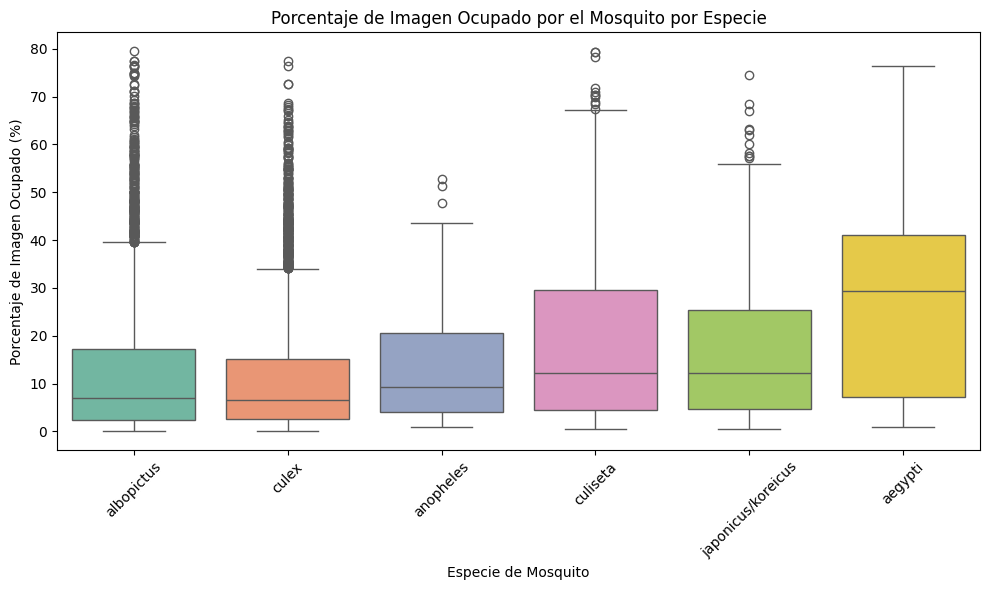

In [25]:
# Crear columna en porcentaje
resumen['bbx_area_percent'] = resumen['bbx_area_rel'] * 100
resumen['class_label'] = train_df_clean['class_label'].values

plt.figure(figsize=(10,6))
sns.boxplot(
    data=resumen,
    x='class_label',
    y='bbx_area_percent',
    palette='Set2'
)
plt.title('Porcentaje de Imagen Ocupado por el Mosquito por Especie')
plt.xlabel('Especie de Mosquito')
plt.ylabel('Porcentaje de Imagen Ocupado (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Esta gráfica busca identificar si el tipo de mosquito influye en que porción de la imagen ocupa el bounding box. En este caso, podemos ver que la mayoría de especies se encuentran con medias y cuartiles similares. Sin embargo, podemos ver outliers más frecuentes en las categorías más populares (```albopictus``` y ```culex```). Por otro lado, la categoríia ```aegypti``` presenta valores de la media significativamente mayores, al igual que una varianza más alta en los valores que puede tomar.

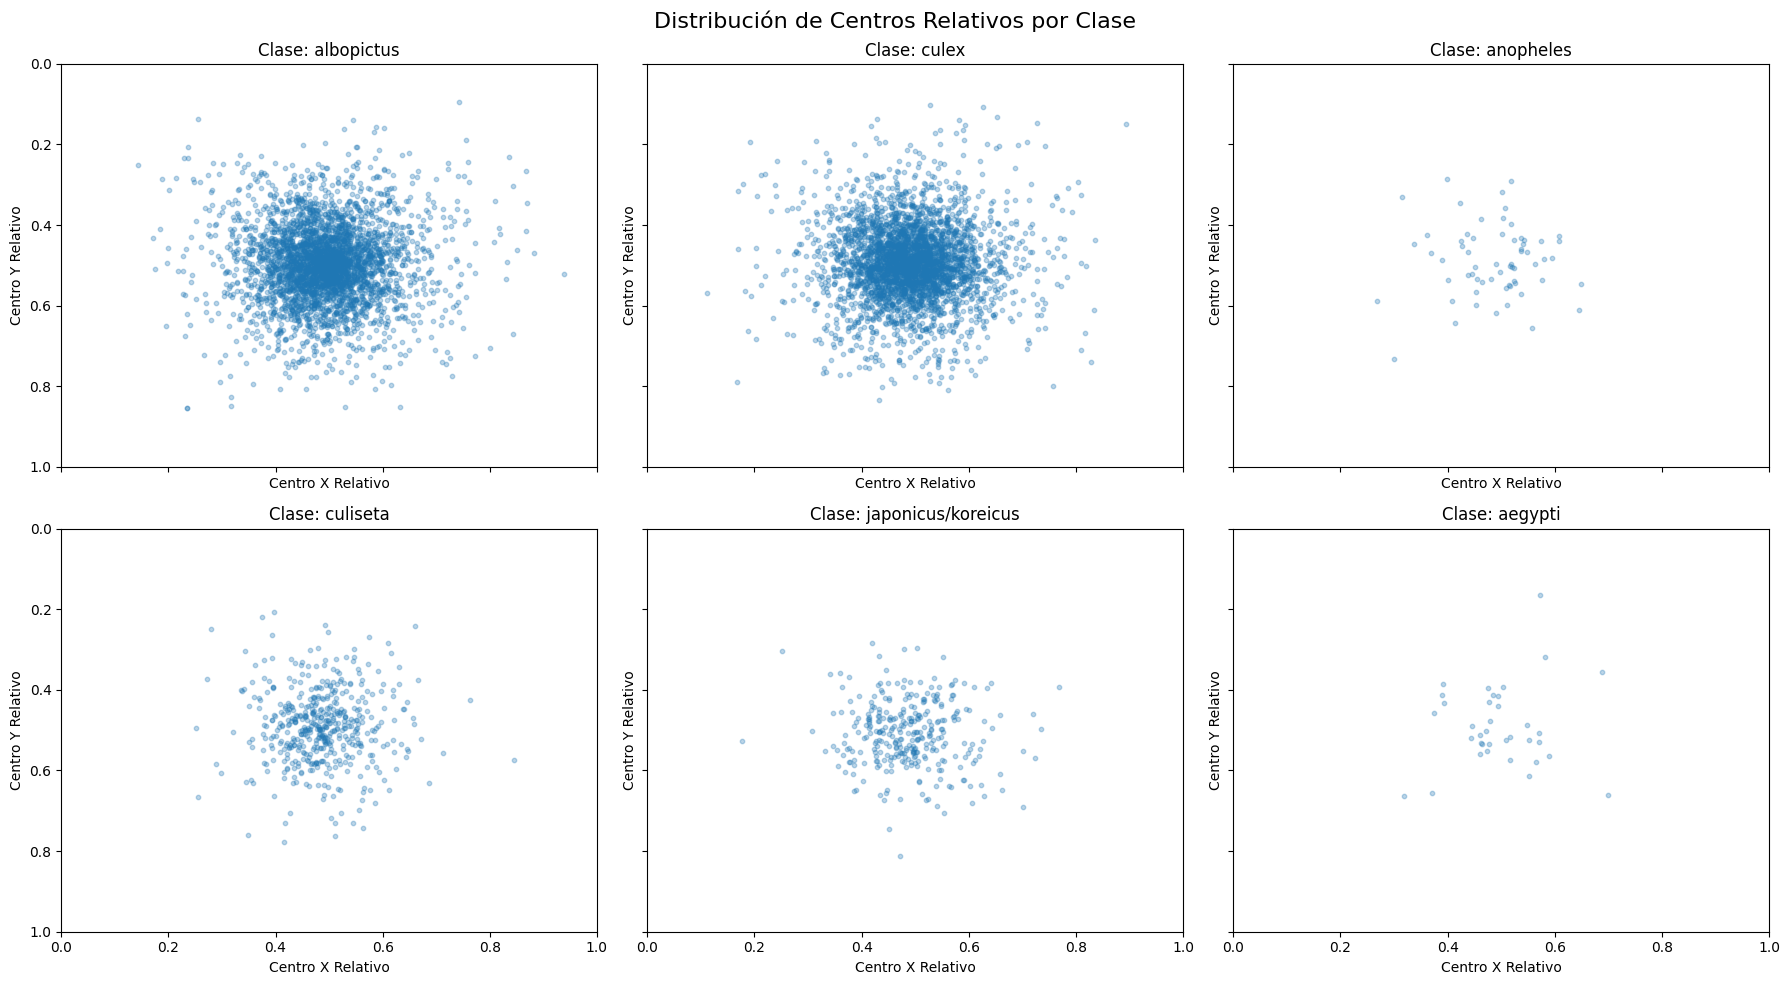

In [26]:
# Scatter de centros relativos
classes = resumen['class_label'].unique()
n_classes = len(classes)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
fig.suptitle('Distribución de Centros Relativos por Clase', fontsize=16)

axes = axes.flatten()

for ax, cls in zip(axes, classes):
    subset = resumen[resumen['class_label'] == cls]
    ax.scatter(subset['bbx_cx_rel'], subset['bbx_cy_rel'], alpha=0.3, s=10)
    ax.set_title(f'Clase: {cls}')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()
    ax.set_xlabel('Centro X Relativo')
    ax.set_ylabel('Centro Y Relativo')

for ax in axes[n_classes:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


En esta gráfica buscamos rela+ciones entre la posición del mosquito dentro de la foto y su especie. En este caso, la distinción más grande entre cada una de las especies es la cantidad de observaciones.  Dónde las clases más populares se ven mucho más claramente sesgadas hacia el centro. Sin embargo, no logramos identificar algún patrón que nos indique preferencia por alguna posición dentro de la imagen para alguna especie de mosquito. Todas las especies, incluyendo ```aegypti``` que contiene un número limitado de observaciones parece tener una variedad de  ubicaciones. Al no observarse patrones claros en la posición del mosquito según la especie; esto confirma que el modelo debe estar preparado para detectar mosquitos en cualquier ubicación dentro de la imagen.

## Hallazgos y Conclusiones

### Hallazgos

El dataset de imágenes del Mosquito Alert Challenge presenta una gran variabilidad en tamaño, resolución y relación de aspecto. Aunque la mayoría de las imágenes se concentran en resoluciones promedio y con proporciones cercanas a 4:3, aproximadamente un cuarto de las imágenes está por debajo de 1.4 MPx y otro cuarto por encima de 12 MPx, lo que muestra diferencias muy marcadas. También se observan formatos extremadamente verticales y horizontales, lo que confirma que el modelo tendrá que enfrentarse a casos atípicos. En general, los bounding boxes están centrados y cubren un área pequeña de la imagen, aunque existen casos donde el mosquito ocupa gran parte de la foto. La matriz de correlación sugiere que el tamaño de la imagen no está relacionado con el del bounding box, y al analizar la posición de los mosquitos no se observan patrones claros por especie. El análisis por clase muestra que la mayoría de las especies comparten rangos de resolución similares, pero especies como anopheles o aegypti presentan distribuciones más “apretadas”, con menos variabilidad en resolución. Esto implica que hay pocas muestras que representen escenarios de resolución extrema para estas clases, lo que puede sesgar el aprendizaje del modelo. Finalmente, el dataset muestra un desbalance notable: albopictus y culex representan cerca del 88 % de las observaciones, mientras que aegypti y anopheles tienen muy pocas muestras. También se observa que algunas especies tienden a tener bounding boxes más grandes o más dispersos que otras.

### Conclusiones

Estos hallazgos indican que el modelo tendrá que ser robusto ante una gran diversidad de resoluciones, tamaños y posiciones de los mosquitos. Será importante aplicar preprocesamiento que normalice o redimensione las imágenes y reduzca el efecto de valores extremos. En el caso de especies con distribuciones de resolución muy estrechas, es recomendable utilizar data augmentation que simule variabilidad adicional para que el modelo no descarte características útiles solo
porque aparecen en imágenes de resolución atípica para esa clase. También será necesario tratar el desbalance de clases con técnicas como oversampling o pesos en la función de pérdida, para evitar que el modelo aprenda a predecir principalmente las especies más frecuentes. Además, la variabilidad en el tamaño y posición de los bounding boxes sugiere que el detector debería considerar distintos rangos de tamaños para mejorar la detección de mosquitos pequeños o en ubicaciones poco comunes. Con estas medidas, el modelo tendrá mejores probabilidades de generalizar bien y detectar correctamente todas las especies, incluso aquellas con menos datos de entrenamiento.

# Entrega 2. Resultados Iniciales

## Pre-Procesamiento

Primero, vamos a definir algunos Pipelines para el preprocesamiento de imagenes. Queremos que todas las imagenes tengan dimensiones consistentes, al igual que ciertas transformaciones. Vamos a realizar un breve sanity-check antes de empezar.

In [27]:
train_df = train_df_clean[[
    "img_fName",
    "img_w",
    "img_h",
    "bbx_xtl",
    "bbx_ytl",
    "bbx_xbr",
    "bbx_ybr",
    "class_label"
]].copy()

train_df.head()


,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,92715872-3287-4bff-aa61-7047973e5c02.jpeg,2448,3264,1301,1546,1641,2096,albopictus
1,b0f7cc74-2272-4756-a387-38bcaf6965c8.jpeg,3024,4032,900,1897,1950,2990,albopictus
2,82df4b68-0f45-4afe-9215-48488bf3720e.jpeg,768,1024,220,58,659,808,albopictus
3,331ad30a-7564-4478-b863-7bc760adf5a1.jpeg,3456,4608,1169,2364,1586,2826,albopictus
4,1a46dbfb-104e-466b-88d7-98958d7b1fe9.jpeg,1024,1365,129,231,697,1007,culex


Podemos ver que el dataset fue cargado correctamente, por lo que podemos proceder. Vamos a empezar definiendo pipelines de "albumentation", esto nos sirve para poder tener una misma dimension en todas las imagenes. Esta transformacion se aplica a cada una de las imagenes del dataset. Adicionalmente, vamos a implementar algunas transformaciones de data augmentation para el set de entrenamiento.

In [28]:
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import WeightedRandomSampler

IMG_SIZE = 320
image_dir = os.path.join(dataset_path, "train_images")

train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

img_labels = train_df[["img_fName", "class_label"]].drop_duplicates()
trainval_imgs, test_imgs = train_test_split(
    img_labels["img_fName"],
    test_size=0.2, random_state=42,
    stratify=img_labels["class_label"]
)
train_imgs, val_imgs = train_test_split(
    trainval_imgs,
    test_size=0.125, random_state=42
)

train_df_split = train_df[train_df["img_fName"].isin(train_imgs)].reset_index(drop=True)
val_df_split   = train_df[train_df["img_fName"].isin(val_imgs)].reset_index(drop=True)
test_df_split  = train_df[train_df["img_fName"].isin(test_imgs)].reset_index(drop=True)

print(f"Train {train_df_split['img_fName'].nunique()} imgs | "
      f"Val {val_df_split['img_fName'].nunique()} imgs | "
      f"Test {test_df_split['img_fName'].nunique()} imgs")



Train 5596 imgs | Val 800 imgs | Test 1600 imgs
✅ weighted sampler ready


Luego, podemos utilizar un weighted sampler para manejar el desbalanceo de clases. En este caso, como podemos ver en el EDA, el dataset cuenta con un desbalanceo bastante pronunciado. Con un sampling basado en class weights, al igual que data augmentation, nos estamos asegurando que aunque las clases tengan menos ejemplos el modelo pueda 'aprender' a identificarlas en diferentes contextos.

In [ ]:
img_labels_train = train_df_split[["img_fName","class_label"]].drop_duplicates()
class_counts = img_labels_train["class_label"].value_counts()
class_weights = 1.0 / class_counts
weights = train_df_split["class_label"].map(class_weights)
sampler = WeightedRandomSampler(weights.values, num_samples=len(weights), replacement=True)
print("Weighted sampler ready")

Ahora, podemos hacer setup del Datatset de Torch. Este nos va a permitir cargar datos utilizando DataLoader, de esta manera no debemos de cargar 5,000+ imagenes dentro de la memoria y podemos utilizar el WeightedRandomSampler directamente.

In [31]:
import torch, cv2, os
from torch.utils.data import Dataset, DataLoader

class MosquitoDataset(Dataset):
    def __init__(self, df_split, img_dir, transform):
        self.df = df_split
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = df_split["img_fName"].unique()
        self.label_map = {l: i for i, l in enumerate(sorted(df_split["class_label"].unique()))}

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        sample_df = self.df[self.df["img_fName"] == img_name]

        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes = sample_df[["bbx_xtl","bbx_ytl","bbx_xbr","bbx_ybr"]].values.tolist()
        labels = [self.label_map[c] for c in sample_df["class_label"].values]

        tr = self.transform(image=img, bboxes=boxes, labels=labels)
        img_t = tr["image"]
        boxes_t = torch.tensor(tr["bboxes"], dtype=torch.float32)
        labels_t = torch.tensor(tr["labels"], dtype=torch.int64)

        return img_t, {"boxes": boxes_t, "labels": labels_t}

Luego de definir el Dataset, ahora podemos definir los DataLoaders que basicamente son nuestros 'conjuntos' de datos. Estos basicamente se encargan de cargar la informacion de MosquitoDataset en diferentes batches para el entrenamiento de los modelos.

In [35]:
from torch.utils.data import DataLoader

train_ds = MosquitoDataset(train_df_split, image_dir, train_tf)
val_ds   = MosquitoDataset(val_df_split,   image_dir, val_tf)
test_ds  = MosquitoDataset(test_df_split,  image_dir, val_tf)

train_loader = DataLoader(train_ds, num_workers=2, batch_size=16, sampler=sampler, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_ds,   num_workers=2, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader  = DataLoader(test_ds,  num_workers=2, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Loaders ready | Train batches: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")

Loaders ready | Train batches: 350 | Val: 50 | Test: 100


## Faster R-CNN

### Entrenamiento

In [42]:
import torch, torchvision, time, psutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df_split["class_label"].unique()) + 1  # +1 for background

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

epochs = 3
print(f"🚀 Starting Faster R-CNN training on {device.type.upper()} | "
      f"{epochs} epochs | {len(train_loader)} batches per epoch\n")

start_time = time.time()

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    epoch_start = time.time()

    print(f"🟢 Epoch {epoch+1}/{epochs} started...")
    for i, (imgs, targets) in enumerate(train_loader):
        batch_start = time.time()

        imgs = [img.to(device, non_blocking=True) for img in imgs]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            loss_dict = model(imgs, targets)
            loss = sum(loss_dict.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

        # 🔹 Print progress every few batches
        if (i + 1) % 20 == 0 or (i + 1) == len(train_loader):
            elapsed = time.time() - batch_start
            print(f"  • Batch {i+1}/{len(train_loader)} | Loss {loss.item():.4f} | Time {elapsed:.2f}s")

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_loader)
    epoch_time = time.time() - epoch_start

    model.train()
    total_val_loss = 0.0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=device.type == "cuda"):
        for imgs, targets in val_loader:
            imgs = [img.to(device, non_blocking=True) for img in imgs]
            targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]
            loss_dict = model(imgs, targets)
            total_val_loss += sum(loss_dict.values()).item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"✅ Epoch {epoch+1} done | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Time: {epoch_time/60:.1f} min")

    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"   🧮 GPU memory used: {alloc:.2f} GB / {total:.1f} GB")
    else:
        print(f"   🧠 CPU memory used: {psutil.virtual_memory().percent:.1f}%")

print(f"\n✅ Training complete in {(time.time()-start_time)/60:.1f} minutes total.")

🚀 Starting Faster R-CNN training on CUDA | 3 epochs | 1399 batches per epoch

🟢 Epoch 1/3 started...
  • Batch 20/1399 | Loss 0.1133 | Time 0.43s
  • Batch 40/1399 | Loss 0.1385 | Time 0.41s
  • Batch 60/1399 | Loss 0.2736 | Time 0.40s
  • Batch 80/1399 | Loss 0.2283 | Time 0.40s
  • Batch 100/1399 | Loss 0.1782 | Time 0.39s
  • Batch 120/1399 | Loss 0.2165 | Time 0.40s
  • Batch 140/1399 | Loss 0.2284 | Time 0.40s
  • Batch 160/1399 | Loss 0.1737 | Time 0.41s
  • Batch 180/1399 | Loss 0.2091 | Time 0.40s
  • Batch 200/1399 | Loss 0.2306 | Time 0.39s
  • Batch 220/1399 | Loss 0.1873 | Time 0.40s
  • Batch 240/1399 | Loss 0.0906 | Time 0.40s
  • Batch 260/1399 | Loss 0.2154 | Time 0.41s
  • Batch 280/1399 | Loss 0.1513 | Time 0.40s
  • Batch 300/1399 | Loss 0.1641 | Time 0.46s
  • Batch 320/1399 | Loss 0.1331 | Time 0.40s
  • Batch 340/1399 | Loss 0.2327 | Time 0.41s
  • Batch 360/1399 | Loss 0.1801 | Time 0.49s
  • Batch 380/1399 | Loss 0.1799 | Time 0.39s
  • Batch 400/1399 | Loss 0.1

Luego del entrenamiento, podemos ver que tomo un total de 32 minutos. Esto puede considerarse relativamente largo, en especial considerando que fueron unicamente tres epocas. Ya con el modelo, podemos ir a evaluar con el conjunto de prueba.

### Prueba

In [44]:
import torch
import numpy as np
from torchvision.ops import box_iou

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IOU_THRESH = 0.5
SCORE_THRESH = 0.5

def evaluate_detector(model, data_loader, iou_thresh=0.5, score_thresh=0.5):
    model.eval()
    total_true, total_pred, total_tp = 0, 0, 0
    iou_scores = []

    with torch.no_grad():
        for imgs, targets in data_loader:
            imgs = [img.to(device) for img in imgs]
            outputs = model(imgs)

            for out, tgt in zip(outputs, targets):
                preds = out["boxes"][out["scores"] > score_thresh].cpu()
                gts   = tgt["boxes"].cpu()

                total_pred += len(preds)
                total_true += len(gts)

                if len(preds) > 0 and len(gts) > 0:
                    ious = box_iou(preds, gts)
                    max_iou, _ = ious.max(dim=1)
                    tp = (max_iou >= iou_thresh).sum().item()
                    total_tp += tp
                    iou_scores.extend(max_iou.tolist())

    precision = total_tp / total_pred if total_pred > 0 else 0.0
    recall    = total_tp / total_true if total_true > 0 else 0.0
    mean_iou  = np.mean(iou_scores) if iou_scores else 0.0
    f1        = 2 * precision * recall / (precision + recall + 1e-6)

    print("📊 Detection metrics:")
    print(f"  • Mean IoU:      {mean_iou:.3f}")
    print(f"  • Precision:     {precision:.3f}")
    print(f"  • Recall:        {recall:.3f}")
    print(f"  • F1-Score:      {f1:.3f}")
    print(f"  • Predictions:   {total_pred} | Ground-truths: {total_true}")
    print(f"  • True Positives {total_tp}")
    return {
        "mean_iou": mean_iou,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": total_tp,
        "pred": total_pred,
        "gt": total_true
    }

print("🔍 Evaluating model on test set...")
metrics = evaluate_detector(model, test_loader,
                            iou_thresh=IOU_THRESH,
                            score_thresh=SCORE_THRESH)

🔍 Evaluating model on test set...
📊 Detection metrics:
  • Mean IoU:      0.715
  • Precision:     0.906
  • Recall:        0.838
  • F1-Score:      0.871
  • Predictions:   1480 | Ground-truths: 1600
  • True Positives 1341


Podemos ver que el modelo tuvo un buen rendimiento. El IoU promedio fue de 0.71 y la precision de 0.906. Sin embargo, debemos de tomar en cuenta que durante la investigacion sobre la competencia se restringio a modelos con unicamente IoU mayor a 0.75, por lo cual podemos decir que el modelo fue bastante debil en este aspecto. Adicionalmente, los valores son un poco 'sesgados' ya que el modelo pudo realizar predicciones (IoU > 0.5 y Score > 0.5). Por lo que a futuro se podria considerar dos modelos diferentes, uno que realice la identificacino de ubicacion y otro que realice la clasificacion

## RetinaNet

In [46]:
import torch, torchvision, time, psutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df_split["class_label"].unique()) + 1

model = torchvision.models.detection.retinanet_resnet50_fpn(weights=None, num_classes=num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

epochs = 3
print(f"🚀 Starting RetinaNet training on {device.type.upper()} | {epochs} epochs | {len(train_loader)} batches per epoch\n")
start_time = time.time()

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    epoch_start = time.time()

    print(f"🟢 Epoch {epoch+1}/{epochs} started...")
    for i, (imgs, targets) in enumerate(train_loader):
        batch_start = time.time()

        imgs = [img.to(device, non_blocking=True) for img in imgs]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            loss_dict = model(imgs, targets)
            loss = sum(loss_dict.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

        if (i + 1) % 20 == 0 or (i + 1) == len(train_loader):
            elapsed = time.time() - batch_start
            print(f"  • Batch {i+1}/{len(train_loader)} | Loss {loss.item():.4f} | Time {elapsed:.2f}s")

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_loader)
    epoch_time = time.time() - epoch_start

    model.train()
    total_val_loss = 0.0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=device.type == "cuda"):
        for imgs, targets in val_loader:
            imgs = [img.to(device, non_blocking=True) for img in imgs]
            targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]
            loss_dict = model(imgs, targets)
            total_val_loss += sum(loss_dict.values()).item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"✅ Epoch {epoch+1} done | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_time/60:.1f} min")

    if torch.cuda.is_available():
        used = torch.cuda.memory_allocated() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"   🧮 GPU memory: {used:.2f} GB / {total:.1f} GB")
    else:
        print(f"   🧠 CPU memory: {psutil.virtual_memory().percent:.1f}%")

print(f"\n✅ RetinaNet training complete in {(time.time()-start_time)/60:.1f} minutes total.")


🚀 Starting RetinaNet training on CUDA | 3 epochs | 1399 batches per epoch

🟢 Epoch 1/3 started...
  • Batch 20/1399 | Loss 1.6273 | Time 0.41s
  • Batch 40/1399 | Loss 1.5721 | Time 0.34s
  • Batch 60/1399 | Loss 1.5606 | Time 0.35s
  • Batch 80/1399 | Loss 1.7573 | Time 0.36s
  • Batch 100/1399 | Loss 1.5273 | Time 0.36s
  • Batch 120/1399 | Loss 1.5910 | Time 0.35s
  • Batch 140/1399 | Loss 1.6096 | Time 0.35s
  • Batch 160/1399 | Loss 1.2987 | Time 0.37s
  • Batch 180/1399 | Loss 1.4609 | Time 0.35s
  • Batch 200/1399 | Loss 1.5556 | Time 0.36s
  • Batch 220/1399 | Loss 1.5199 | Time 0.34s
  • Batch 240/1399 | Loss 1.4301 | Time 0.34s
  • Batch 260/1399 | Loss 1.5396 | Time 0.35s
  • Batch 280/1399 | Loss 1.3743 | Time 0.35s
  • Batch 300/1399 | Loss 1.3890 | Time 0.35s
  • Batch 320/1399 | Loss 1.2451 | Time 0.37s
  • Batch 340/1399 | Loss 1.2557 | Time 0.40s
  • Batch 360/1399 | Loss 1.6897 | Time 0.35s
  • Batch 380/1399 | Loss 1.6530 | Time 0.37s
  • Batch 400/1399 | Loss 1.5981

Luego del entrenamiento, podemos ver que este modelo fue ligeramente mas rapido que el anterior. Siguen siendo modelos algo tardados, sin embargo esto es de esperarse al ser modelos de vision por computadora.

In [51]:
metrics = evaluate_detector(model, test_loader, iou_thresh=0.5, score_thresh=0.5)

🔍 Evaluating model on test set...

📊 Detection metrics:
  • Mean IoU:      0.814
  • Precision:     0.456
  • Recall:        0.498
  • F1-Score:      0.476
  • Predictions:   1748 | Ground-truths: 1600
  • True Positives 797
⏱️  Evaluation time: 116.69 sec



En comparacion al modelo anterior, este fue claramente superior en cuanto a la identificacion de la ubicacion de los mosquitos. Podemos darnos cuenta que el IoU es de 0.814, sin embargo las metricas de clasificacion muestran una clara desventaja. Podriamos a futuro explorar modelos 'combinados', ya que este tuvo mejores metricas de deteccion de objetos con un menor tiempo de entrenamiento.

## SSD300 VGG16

In [63]:
import torch, torchvision, time, psutil
from torchvision.models.detection import ssd300_vgg16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df_split["class_label"].unique()) + 1  # +1 for background

model = ssd300_vgg16(weights=None, num_classes=num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")
max_norm = 1.0  # gradient-clipping limit

epochs = 3
print(f"🚀 Starting SSD300-VGG16 training on {device.type.upper()} | "
      f"{epochs} epochs | {len(train_loader)} batches per epoch\n")

start_time = time.time()
for epoch in range(epochs):
    model.train(); total_loss = 0.0; epoch_start = time.time()
    print(f"🟢 Epoch {epoch+1}/{epochs} started...")

    for i, (imgs, targets) in enumerate(train_loader):
        imgs = [img.to(device, non_blocking=True) for img in imgs]
        targets = [{k: v.to(device, non_blocking=True) for k,v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            loss_dict = model(imgs, targets)
            loss = sum(loss_dict.values())

        if not torch.isfinite(loss):
            print(f"⚠️ Skipping batch {i+1}: non-finite loss {loss.item():.3f}")
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

        if (i+1)%20==0:
            print(f"  • Batch {i+1}/{len(train_loader)} | Loss {loss.item():.4f}")

    scheduler.step()
    avg_train_loss = total_loss / len(train_loader)
    epoch_time = time.time() - epoch_start
    print(f"✅ Epoch {epoch+1} done | Avg Train Loss: {avg_train_loss:.4f} | Time: {epoch_time/60:.1f} min")

print(f"\n✅ SSD300 training complete in {(time.time()-start_time)/60:.1f} minutes total.")

🚀 Starting SSD300-VGG16 training on CUDA | 3 epochs | 1399 batches per epoch

🟢 Epoch 1/3 started...
  • Batch 20/1399 | Loss 147.0217
  • Batch 40/1399 | Loss 28.6866
  • Batch 60/1399 | Loss 16.3175
  • Batch 80/1399 | Loss 8.7375
  • Batch 100/1399 | Loss 10.4777
  • Batch 120/1399 | Loss 10.4255
  • Batch 140/1399 | Loss 10.6816
  • Batch 160/1399 | Loss 8.0797
  • Batch 180/1399 | Loss 7.0917
  • Batch 200/1399 | Loss 10.4321
  • Batch 220/1399 | Loss 9.7166
⚠️ Skipping batch 239: non-finite loss nan
  • Batch 240/1399 | Loss 7.8339
  • Batch 260/1399 | Loss 8.4284
⚠️ Skipping batch 261: non-finite loss nan
  • Batch 280/1399 | Loss 7.5721
  • Batch 300/1399 | Loss 10.0940
  • Batch 320/1399 | Loss 8.0103
  • Batch 340/1399 | Loss 7.4140
  • Batch 360/1399 | Loss 9.1317
  • Batch 380/1399 | Loss 9.3305
  • Batch 400/1399 | Loss 9.3213
  • Batch 420/1399 | Loss 8.6053
  • Batch 440/1399 | Loss 8.6517
  • Batch 460/1399 | Loss 5.2627
  • Batch 480/1399 | Loss 7.4053
  • Batch 500/13

Podemos ver que este modelo es em mas eficiente en tiempo, por bastante. En este caso, el tiempo de entrenamiento es alrededor de 3 veces menor en comparacion al modelo mas tardado. Esto lo hace mas apto para situaciones donde la capacidad de computo es limitada. A continuacion, podemos evaluar su rendimiento. Adicionalmente, en este caso debemos realizar algunas transformaciones debido a como funciona el modelo.

In [68]:
import torch, numpy as np
from torchvision.ops import box_iou

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🔍 Evaluating SSD300-VGG16 on test set...")
model.eval().to(device)

IOU_THRESH = 0.5
SCORE_THRESH = 0.2

total_true, total_pred, total_tp = 0, 0, 0
iou_scores = []
skipped = 0

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)

        for out, tgt in zip(outputs, targets):
            # skip if malformed
            if "boxes" not in out:
                skipped += 1
                continue

            preds = out["boxes"].detach().to(device)
            scores = out.get("scores", torch.ones(len(preds), device=device))
            keep = scores > SCORE_THRESH
            preds = preds[keep]
            gts = tgt["boxes"].to(device)

            total_pred += len(preds)
            total_true += len(gts)

            if len(preds) == 0 or len(gts) == 0:
                continue

            ious = box_iou(preds, gts)
            matched_gt = set()
            for i in range(len(preds)):
                max_iou, max_j = ious[i].max(dim=0)
                if max_iou >= IOU_THRESH and int(max_j) not in matched_gt:
                    total_tp += 1
                    matched_gt.add(int(max_j))
                    iou_scores.append(max_iou.item())

precision = total_tp / total_pred if total_pred > 0 else 0.0
recall = total_tp / total_true if total_true > 0 else 0.0
mean_iou = np.mean(iou_scores) if iou_scores else 0.0
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("📊 Detection metrics:")
print(f"  • Mean IoU:      {mean_iou:.3f}")
print(f"  • Precision:     {precision:.3f}")
print(f"  • Recall:        {recall:.3f}")
print(f"  • F1-Score:      {f1:.3f}")
print(f"  • Predictions:   {total_pred} | Ground-truths: {total_true}")
print(f"  • True Positives {total_tp} | Skipped {skipped}")

🔍 Evaluating SSD300-VGG16 on test set...
📊 Detection metrics:
  • Mean IoU:      0.672
  • Precision:     0.554
  • Recall:        0.019
  • F1-Score:      0.037
  • Predictions:   56 | Ground-truths: 1600
  • True Positives 31 | Skipped 0


Para este modelo, al correrlo con parametros similares a los anteriores no se obtuvieron predicciones. Esto nos puede decir que el modelo realmente no tiene mucha confianza, o que realmente no es tan capaz de realizar predicciones precisas. Luego de variar ligeramente los parametros, podemos darnos cuenta que unicamente realizo 56 predicciones. Adicionalmente, las metricas de clasificacion son sumamente bajas. Realmente podemos decir que este modelo a pesar de sus requerimientos computacionales mas bajos, sigue siendo inferior a los demas.

# Visualizaciones

Primero, vamos a cargar los datos obtenidos de los outputs anteriores. Esto para evitar re-entrenar los modelos.

In [69]:
# --- MODEL COMPARISON TABLE ---
import pandas as pd

results = [
    {
        "Model": "SSD300-VGG16",
        "Train Time (min)": 13.4,
        "Mean IoU": 0.672,
        "Precision": 0.554,
        "Recall": 0.019,
        "F1-Score": 0.037,
    },
    {
        "Model": "RetinaNet-ResNet50",
        "Train Time (min)": 27.1,
        "Mean IoU": 0.814,
        "Precision": 0.456,
        "Recall": 0.498,
        "F1-Score": 0.476,
    },
    {
        "Model": "Faster R-CNN-ResNet50",
        "Train Time (min)": 32.0,
        "Mean IoU": 0.715,
        "Precision": 0.906,
        "Recall": 0.838,
        "F1-Score": 0.871,
    },
]

df_metrics = pd.DataFrame(results)
display(df_metrics)

,Model,Train Time (min),Mean IoU,Precision,Recall,F1-Score
0,SSD300-VGG16,13.400000,0.672000,0.554000,0.019000,0.037000
1,RetinaNet-ResNet50,27.100000,0.814000,0.456000,0.498000,0.476000
2,Faster R-CNN-ResNet50,32.000000,0.715000,0.906000,0.838000,0.871000


## Tiempo de Entrenamiento

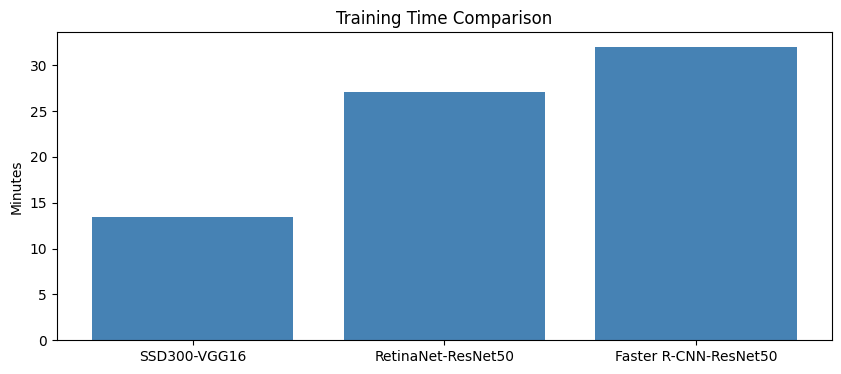

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(df_metrics["Model"], df_metrics["Train Time (min)"], color="steelblue")
plt.title("Training Time Comparison")
plt.ylabel("Minutes")
plt.show()

Podemos ver que en cuanto a tiempo de entrenamiento, SSD300 es el mejor. Sin embargo, debido a sus metricas y poca capacidad de realizar predicciones consideramos que es inapropiado considerarlo en las comparativas. En cuanto a los otros dos, RetinaNet y Faster R-CNN tienen tiempos similares. En realidad, consideramos que estos modelos mas tardados proveen un 'baseline' de tiempos de entrenamiento para modelos de vision por computadora. Ya que al buscar modelos mas rapidos, el rendimiento es inferior.

## IoU

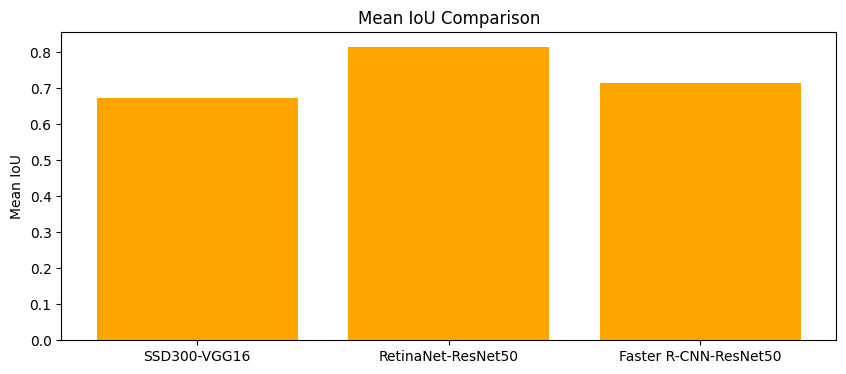

In [71]:
plt.figure(figsize=(10, 4))
plt.bar(df_metrics["Model"], df_metrics["Mean IoU"], color="orange")
plt.title("Mean IoU Comparison")
plt.ylabel("Mean IoU")
plt.show()

Viendo el IoU, primero debemos de notar que este promedio es unicamente sobre las predicciones realizadas. Estas fueron restringidas a IoU > 0.5, por lo cual las predicciones se van a encontrar por encima de este promedio y la escala se debe comparar en valores superiores. Creemos que el modelo de RetinaNet probo ser superior, seguido por R-CNN. A futuro, se puede considerar un modelo hibrido.

## F1 Score

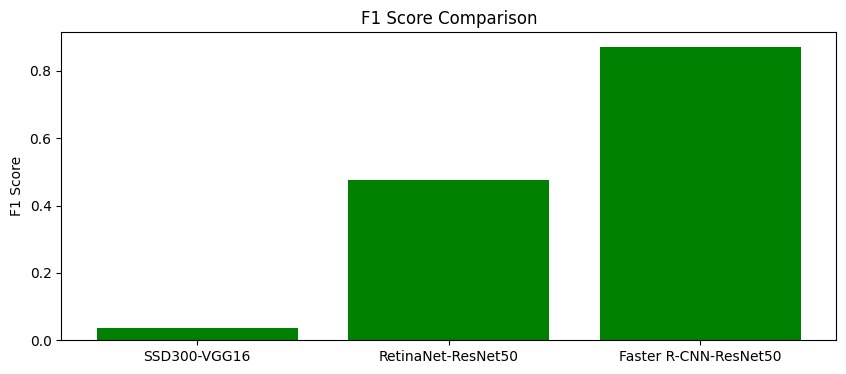

In [72]:
plt.figure(figsize=(10, 4))
plt.bar(df_metrics["Model"], df_metrics["F1-Score"], color="green")
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.show()

En cuanto a las metricas de clasificacion, podemos darnos cuenta que Faster R-CNN tuvo un rendimiento superior a los demas. Esto teniendo en cuenta que se realizaron predicciones unicamente para IoU > 0.5 y Score > 0.5, por lo que se debe mencionar que tenemos algunas imagenes para las cuales se considero incapaz de realizar predicciones.